$\newcommand{\TirName}[1]{\text{#1}}
\newcommand{\inferrule}[3][]{
  \let\and\qquad
  \begin{array}{@{}l@{}}
  \TirName{#1}
  \\
  \displaystyle
  \frac{#2}{#3}
  \end{array}
}
\newcommand{\infer}[3][]{\inferrule[#1]{#2}{#3}}
$

# Meeting 27 - Procedural Abstraction

Bor-Yuh Evan Chang  
Tuesday, December 3, 2024

<!-- 3 Expressions -->

<!-- 4 Binding and Scope -->

<!-- 8 Recursion -->

<!-- 9 Inductive Data Types -->

<!-- 11 Concrete Syntax -->

<!-- 12 Abstract Syntax and Parsing -->

<!-- 13 Exercise: Syntax -->

<!-- 14 Static Scoping -->

<!-- 15 Judgments -->

<!-- 16 Variables, Basic Values, and Judgments Lab -->

<!-- 18 Operational Semantics -->

<!-- 19 Functions and Dynamic Scoping -->

<!-- 20 Big-Step Exercise -->

<!-- 21 Evaluation Order  -->

<!-- 26 Static Type Checking -->

<!-- 27 Lazy Evaluation -->

<!-- 28 Objects -->

<!-- 28 Static Type Checking Lab -->

<!-- 30 Mutable State -->

<!-- Encapsulating Effects Exercise -->

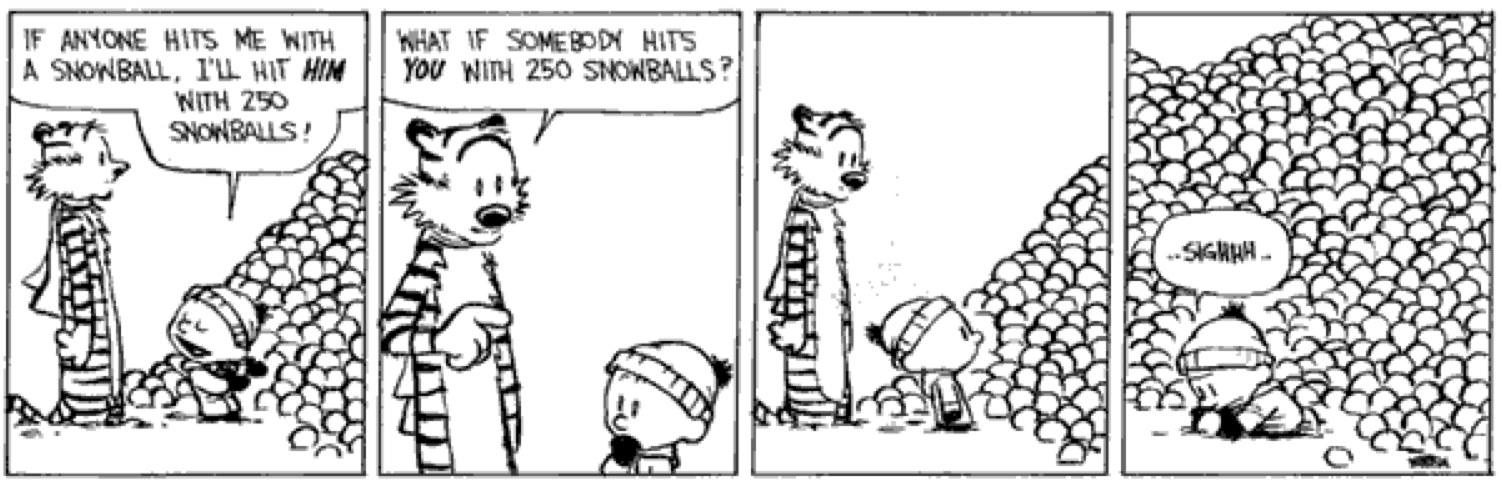

What questions does your neighbor have?

## Links

[ In-Class Slides](in-class/meeting27-encapsulating-effects.pdf)<br/> [
In-Class Jupyter](in-class/meeting27-encapsulating-effects.ipynb)<br/>

## Announcements

-   Remainder of the Semester
    -   HW 5 ~~and Lab 5~~ before Thanksgiving break
    -   ~~Unit 6 (probably one combined assignment)~~ Lab 5 after
        Thanksgiving break
    -   Exam 5~~-6~~ in the last week of classes before the Final
-   [Come see us to make a study
    plan](https://piazza.com/class/m090yd3cdrb1ti/post/415)
    -   e.g., via the redo policy
    -   see the Final Exam as an opportunity to show growth from
        mid-semester exams.

## Today

-   [Procedural
    Abstraction](https://csci3155.cs.colorado.edu/pppl-course/book/procedural-abstraction.html)
    -   [Lazy
        Evaluation](https://csci3155.cs.colorado.edu/pppl-course/book/lazy-evaluation.html)
    -   [Mutable
        State](https://csci3155.cs.colorado.edu/pppl-course/book/mutable-state.html)
-   Triage Your Questions

## Questions?

-   Review:
    -   What is the essence of imperative computation?

## Procedures

What are *procedures*?

## Assignment

$$
\begin{array}{rrrl}
  \text{expressions} & e& \mathrel{::=}& \cdots \mid x \mathrel{\texttt{=}}e_1
\end{array}
$$

What if we applied substitution as before?

## Static Memory

Without procedure call, dynamically-allocated memory addresses seems
overkill. $$
\begin{array}{rrrl}
\text{memories} & m& \mathrel{::=}& \cdot\mid m[x \mapsto v]
\end{array}
$$

## Procedures: Syntax

$$
\begin{array}{rrrl}
  \text{types} & \tau& \mathrel{::=}& \texttt{number}\mid\texttt{(}x\texttt{:}\, \mathbf{var}\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} \tau'
  \\
  \text{values} & v& \mathrel{::=}& n\mid\texttt{(}x\texttt{:}\, \mathbf{var}\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} e_1
  \\
  \text{expressions} & e& \mathrel{::=}& n\mid\texttt{(}x\texttt{:}\, \mathbf{var}\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} e_1
  \mid x
  \mid e_1\texttt{(}e_2\texttt{)}
  \mid x \mathrel{\texttt{=}}e_1
  \mid\mathord{\texttt{*}}a
\end{array}
$$

Figure 1: Syntax of TypeScripty with number literals, procedure
literals, procedure calls, and mutable variable assignment.

## Procedures: Semantics

## Procedures: Implementation

In [1]:
trait Expr                                                     // e
case class N(n: Double) extends Expr                           // e ::= n
case class Var(x: String) extends Expr                         // e ::= x
case class Assign(e1: Expr, e2: Expr) extends Expr             // e ::= e1 = e2
case class Deref(e1: Expr) extends Expr                        // e ::= *e1
case class A(a: Int) extends Expr                              // e ::= a

def isValue(e: Expr): Boolean = e match {
  case N(_) => true
  case _ => false
}

defined trait Expr
defined class N
defined class Var
defined class Assign
defined class Deref
defined class A
defined function isValue

In [2]:
sealed class Mem private (m: Map[A, Expr], nextAddr: Int) {
  def apply(a: A): Expr = m(a)
  override def toString: String = m.toString

  def +(av: (A, Expr)): Mem = {
    val (a, _) = av
    require(m.contains(a))
    new Mem(m + av, nextAddr)
  }

  def alloc(v: Expr): (A, Mem) = {
    val fresha = A(nextAddr)
    (fresha, new Mem(m + (fresha -> v), nextAddr + 1))
  }
}

object Mem {
  val empty: Mem = new Mem(Map.empty, 1)
}

defined class Mem
defined object Mem

In [3]:
sealed class DoWith[S, A] private (doer: S => (S, A)) {
  def map[B](f: A => B): DoWith[S, B] = new DoWith[S, B]({ (s: S) => { val (s_, a) = doer(s); (s_, f(a)) } })
  def flatMap[B](f: A => DoWith[S, B]): DoWith[S, B] = new DoWith[S, B]({ (s: S) => { val (s_, a) = doer(s); f(a)(s_) } })
  def apply(s: S): (S, A) = doer(s)
}

object DoWith {
  def doget[S]: DoWith[S, S] = new DoWith[S, S]({ s => (s, s) })
  def doput[S](s: S): DoWith[S, Unit] = new DoWith[S, Unit]({ _ => (s, ()) })
  def doreturn[S, A](a: A): DoWith[S, A] = new DoWith[S, A]({ s => (s, a) })
  def domodify[S](f: S => S): DoWith[S, Unit] = new DoWith[S, Unit]({ s => (f(s), ()) })
}

import DoWith._

defined class DoWith
defined object DoWith
import DoWith._

In [4]:
def memalloc(v: Expr): DoWith[Mem, A] = doget flatMap { m =>
  val (a, m_) = m.alloc(v)
  doput(m_) map { _ => a }
}

defined function memalloc

In [5]:
def substitute(with_e: Expr, x: String, in_e: Expr) = {
  // Assume that with_e and in_e have non-intersecting free variables.
  def $(in_e: Expr): Expr = in_e match {
    case N(_) | A(_) => in_e
    case Var(y) => if (x == y) with_e else in_e
    case Assign(e1, e2) => Assign($(e1), $(e2))
    case Deref(e1) => Deref($(e1))
  }
  $(in_e)
}

defined function substitute

In [6]:
def step(e: Expr): DoWith[Mem, Expr] = ???

defined function step

# Parameter-Passing Modes

Small changes in $\TirName{DoCall}$.

## Call-By-Name Parameters: Syntax

$$
\begin{array}{rrrl}
  \text{types} & \tau& \mathrel{::=}& \texttt{number}\mid\texttt{(}x\texttt{:}\, m\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} \tau'
  \\
  \text{values} & v& \mathrel{::=}& n\mid\texttt{(}x\texttt{:}\, m\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} e_1
  \\
  \text{expressions} & e& \mathrel{::=}& n\mid\texttt{(}x\texttt{:}\, m\,\tau \texttt{)} \mathrel{\texttt{=}\!\texttt{>}} e_1
  \mid x
  \mid e_1\texttt{(}e_2\texttt{)}
  \mid m\;x\;\texttt{=}\;e_1\texttt{;}\;e_2
  \\
  \text{parameter modes} & m& \mathrel{::=}& \mathbf{const}\mid\mathbf{name}
\end{array}
$$

Figure 2: Syntax of TypeScripty with number literals, function literals
with parameter modes, and variable declarations, and function call
expressions.

## Call-By-Name Parameters: Semantics

## Exotic Parameter-Passing Modes

Reference parameters (as in C++ and C#)?

Out parameters (as in C#)?

In-out parameters (as in Ada)?

# Pointers

First-class addresses (i.e., when “addresses are values”).

## Dynamically-Allocated Mutable Objects: Syntax

$$
\begin{array}{rrrl}
  \text{expressions} & e& \mathrel{::=}& n
  \mid\texttt{\{} \overline{ f\texttt{:}\,e } \texttt{\}}
  \mid e_1 \mathrel{\texttt{=}}e_2
  \mid e_1\texttt{.}f
  \mid x
  \mid\mathbf{const}\;x\;\texttt{=}\;e_1\texttt{;}\;e_2
  \\
  \text{values} & v& \mathrel{::=}& n\mid a
  \\
  \text{location values} & l& \mathrel{::=}& a\texttt{.}f
  \\
  \text{addresses} & a
\end{array}
$$

Figure 3: Syntax of TypeScripty with number literals and
dynamically-allocated mutable objects.

## Dynamically-Allocated Mutable Objects: Semantics

## Dynamically-Allocated Mutable Objects: Semantics

## Aliasing

``` js
const a = { val: 1 };
const b = a;
b.val = 42;
console.log(a.val)
```